# Redes Neurais
## 1ª Lista de Exercícios - Classificação de padrões


Aluno: Paloma Fernanda Loureiro Sette

Matrícula: 1621595

Base de dados:  c_occupancy_detection.csv

### Para cada item da lista de exercício, não esqueça de fazer uma análise pertinente dos resultados obtidos.

<b> Importante: </b> faça uma média dos resultados para cada item. Como o modelo é estocástico, os resultados podem variar de acordo com a inicialização dos pesos.

In [2]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt 
import seaborn as sns 
from time import sleep
import requests

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from utils import CustomDataset, transform_data, plot_confusion_matrix
from model_utils import train


In [3]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    
    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

  def predict(self, x, binary=True):
    y_hat = self.forward(x)

    if binary:
      y_pred = torch.round(torch.sigmoid(y_hat))
      y_pred = y_pred.detach().numpy()
    else:
      y_pred = torch.argmax(y_hat, dim=1)

    return y_pred

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preparação dos dados

Não esqueça de verificar o path para a pasta. Mude também o filename, de acordo com a base de dados.

In [145]:
dataset_name = 'occupancy_detection'
dataset_path = f'https://raw.githubusercontent.com/palomaflsette/PUC_Redes_Neurais/main/datasets/c_{dataset_name}.csv'
info_path = f'https://raw.githubusercontent.com/palomaflsette/PUC_Redes_Neurais/main/datasets/data_info/{dataset_name}/data_info.json'
dataset = pd.read_csv(dataset_path)

In [146]:
resp = requests.get(info_path, verify=False)
info = json.loads(resp.text)

c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [147]:
for col, k in info.items():
    if k == 'categorical':
        dataset[col] = dataset[col].astype(object)

In [148]:
for i in dataset.dtypes.items():
    print(i)

('date', dtype('O'))
('Temperature', dtype('float64'))
('Humidity', dtype('float64'))
('Light', dtype('float64'))
('CO2', dtype('float64'))
('HumidityRatio', dtype('float64'))
('target', dtype('int64'))


In [149]:
# função para converter a hora no formato HH:MM:SS para double
def time_to_decimal(time_str):
    time_str = time_str.split(" ")[1]
    hours, minutes, seconds = map(int, time_str.split(":"))
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds / 3600


## Parte I - Compreensão do problema e análise de variáveis

Total: 1,0 pts.


### 1)	Observe a base de dados do problema. Existem variáveis que podem ser eliminadas do dataset? Justifique.

Antes de prosseguir com o desenvolvimento deste item, é interessante refletirmos sobre os dados que o dataset expõe. Uma visão geral das colunas:

* date: Data e hora da observação (tipo object).
* Temperature: Temperatura do ambiente (em graus Celsius).
* Humidity: Umidade do ambiente (em percentual).
* Light: Iluminação do ambiente (em Lux).
* CO2: Níveis de CO2 no ambiente (em ppm - partes por milhão).
* HumidityRatio: Proporção de umidade no ambiente.
* target: Variável alvo, indicando ocupação (1 para ocupado, 0 para não ocupado).

É necessário analisar cada variável do dataset para determinar se alguma delas não contribui para a capacidade do modelo de fazer previsões. Existem algumas razões pelas quais podemos decidir eliminar uma variável:

* Redundância: Se duas variáveis forem altamente correlacionadas, uma delas pode ser redundante.
* Irrelevância: Se uma variável não tiver nenhuma correlação ou tiver uma correlação muito baixa com a variável alvo, ela pode não ser útil.
* Demasiados Valores Ausentes: Se uma variável contiver muitos valores ausentes, ela pode não ser confiável ou útil.
* Ruído: Se a variável for muito ruidosa ou inconsistente, pode prejudicar o modelo em vez de ajudar.


Para saber se existem variáveis que podem ser eliminadas do dataset, podemos realizar algumas análises:

* Análise de Variância: Variáveis com baixa variância podem não ser úteis para o modelo, pois não variam muito em relação ao alvo.
* Multicolinearidade: Variáveis que estão altamente correlacionadas entre si podem ser candidatas a serem removidas para reduzir a redundância.
* Análise de Importância de Características: Técnicas como Random Forest ou outras podem ser usadas para avaliar a importância de cada característica na previsão da variável alvo.
* Considerações de Domínio: Conhecimento especializado do domínio pode indicar se algumas variáveis são irrelevantes para o problema.

Baseando-se nas informações do dataset, poderíamos fazer algumas considerações:

* A coluna `date` pode não ser diretamente útil para modelos de machine learning em sua forma atual, mas pode ser transformada em características mais úteis, como hora do dia, dia da semana, etc.
* Variáveis como `Temperature`, `Humidity`, `Light`, e `CO2` são medidas ambientais que provavelmente são importantes para a detecção da ocupação, então seria prudente mantê-las até que a análise de dados demonstre o contrário.
* `HumidityRatio` é uma característica derivada que pode estar correlacionada com a `Humidity`. Se a correlação for muito alta, uma das variáveis pode ser redundante.
* A `target` é a variável alvo e não deve ser removida, pois é o que estamos tentando prever.


Portanto, podemos realizar uma análise de correlação para determinar a força e direção da relação entre determinadas variáveis. Num contexto de preparação de dados, é uma análise que pode ajudar a identificar pares de variáveis que estão fortemente correlacionadas que um deles pode ser redundante.

#### Resposta

##### Análise de Correlação

In [150]:
df = dataset.copy()

df['date'] = pd.to_datetime(df['date'])

# Criando novas colunas numéricas com informações extraídas da coluna de data
df['hour'] = df['date'].astype(str).apply(time_to_decimal)
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
# desconsideramos o mês, já que o dataset expõe dados apenas do mês de fevereiro, então vamos considerar que
# todas as análises são para o mês de fevereiro

del df['date']
correlation_matrix = df.corr()

In [151]:
# matriz de correlação
correlation_matrix

,Temperature,Humidity,Light,CO2,HumidityRatio,target,hour,day_of_week,day_of_month
Temperature,1.000000,-0.141759,0.649942,0.559894,0.151762,0.538220,0.259958,-0.236655,-0.476898
Humidity,-0.141759,1.000000,0.037828,0.439023,0.955198,0.132964,0.016974,-0.456780,0.623248
Light,0.649942,0.037828,1.000000,0.664022,0.230420,0.907352,0.085417,-0.160210,-0.133959
CO2,0.559894,0.439023,0.664022,1.000000,0.626556,0.712235,0.209348,-0.472879,0.082218
HumidityRatio,0.151762,0.955198,0.230420,0.626556,1.000000,0.300282,0.095987,-0.537909,0.474664
target,0.538220,0.132964,0.907352,0.712235,0.300282,1.000000,0.080198,-0.251973,-0.109835
hour,0.259958,0.016974,0.085417,0.209348,0.095987,0.080198,1.000000,0.044203,-0.229756
day_of_week,-0.236655,-0.456780,-0.160210,-0.472879,-0.537909,-0.251973,0.044203,1.000000,-0.294621
day_of_month,-0.476898,0.623248,-0.133959,0.082218,0.474664,-0.109835,-0.229756,-0.294621,1.000000


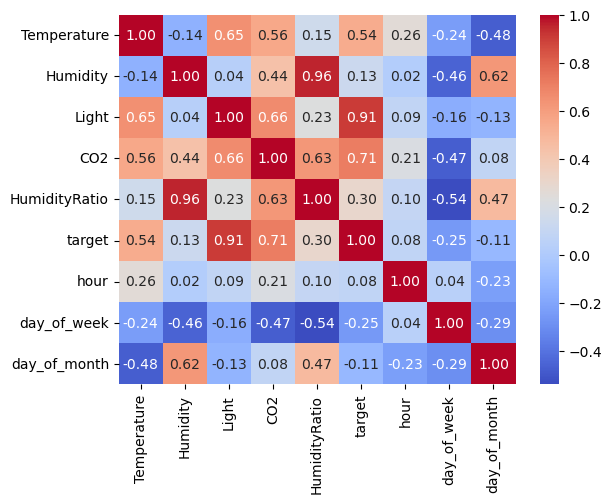

In [153]:
# mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

Analisando os dados da matriz de correlação, podemos perceber:

* Variáveis `Humidity` e `HumidityRatio`: Ambas estão fortemente correlacionadas uma com a outra, o que sugere redundância. A umidade relativa (`Humidity`) é um bom indicador do conforto do ambiente e, junto com a temperatura, pode influenciar o `HumidityRatio`. A menos que o `HumidityRatio` fornecesse informações únicas que a umidade por si só não fornece, poderíamos considerar remover uma delas para simplificar o modelo.

* Variáveis `hour` e `day_of_week`: Apesar de sua correlação não ser tão forte com `target`, elas podem capturar padrões de ocupação que não são imediatamente aparentes apenas olhando para as correlações lineares. Por exemplo, pode haver horários específicos do dia ou dias específicos da semana em que a ocupação é consistentemente mais alta ou mais baixa.

* Dia do Mês (`day_of_month`): Apesar de sua correlação negativa com `target`, seria interessante entender melhor se há eventos recorrentes que possam influenciar a ocupação em dias específicos do mês.


Portanto, `HumidityRatio` (ou `Humidity` se for considerado que `HumidityRatio` fornece mais insights) poderia ser candidata a ser removida. 

### 2)	Implemente técnicas de visualização de dados e seleção de variáveis para extrair características importantes sobre a base de dados. Explique a motivação destas técnicas e o que é possível inferir dos resultados obtidos.

#### Resposta

c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


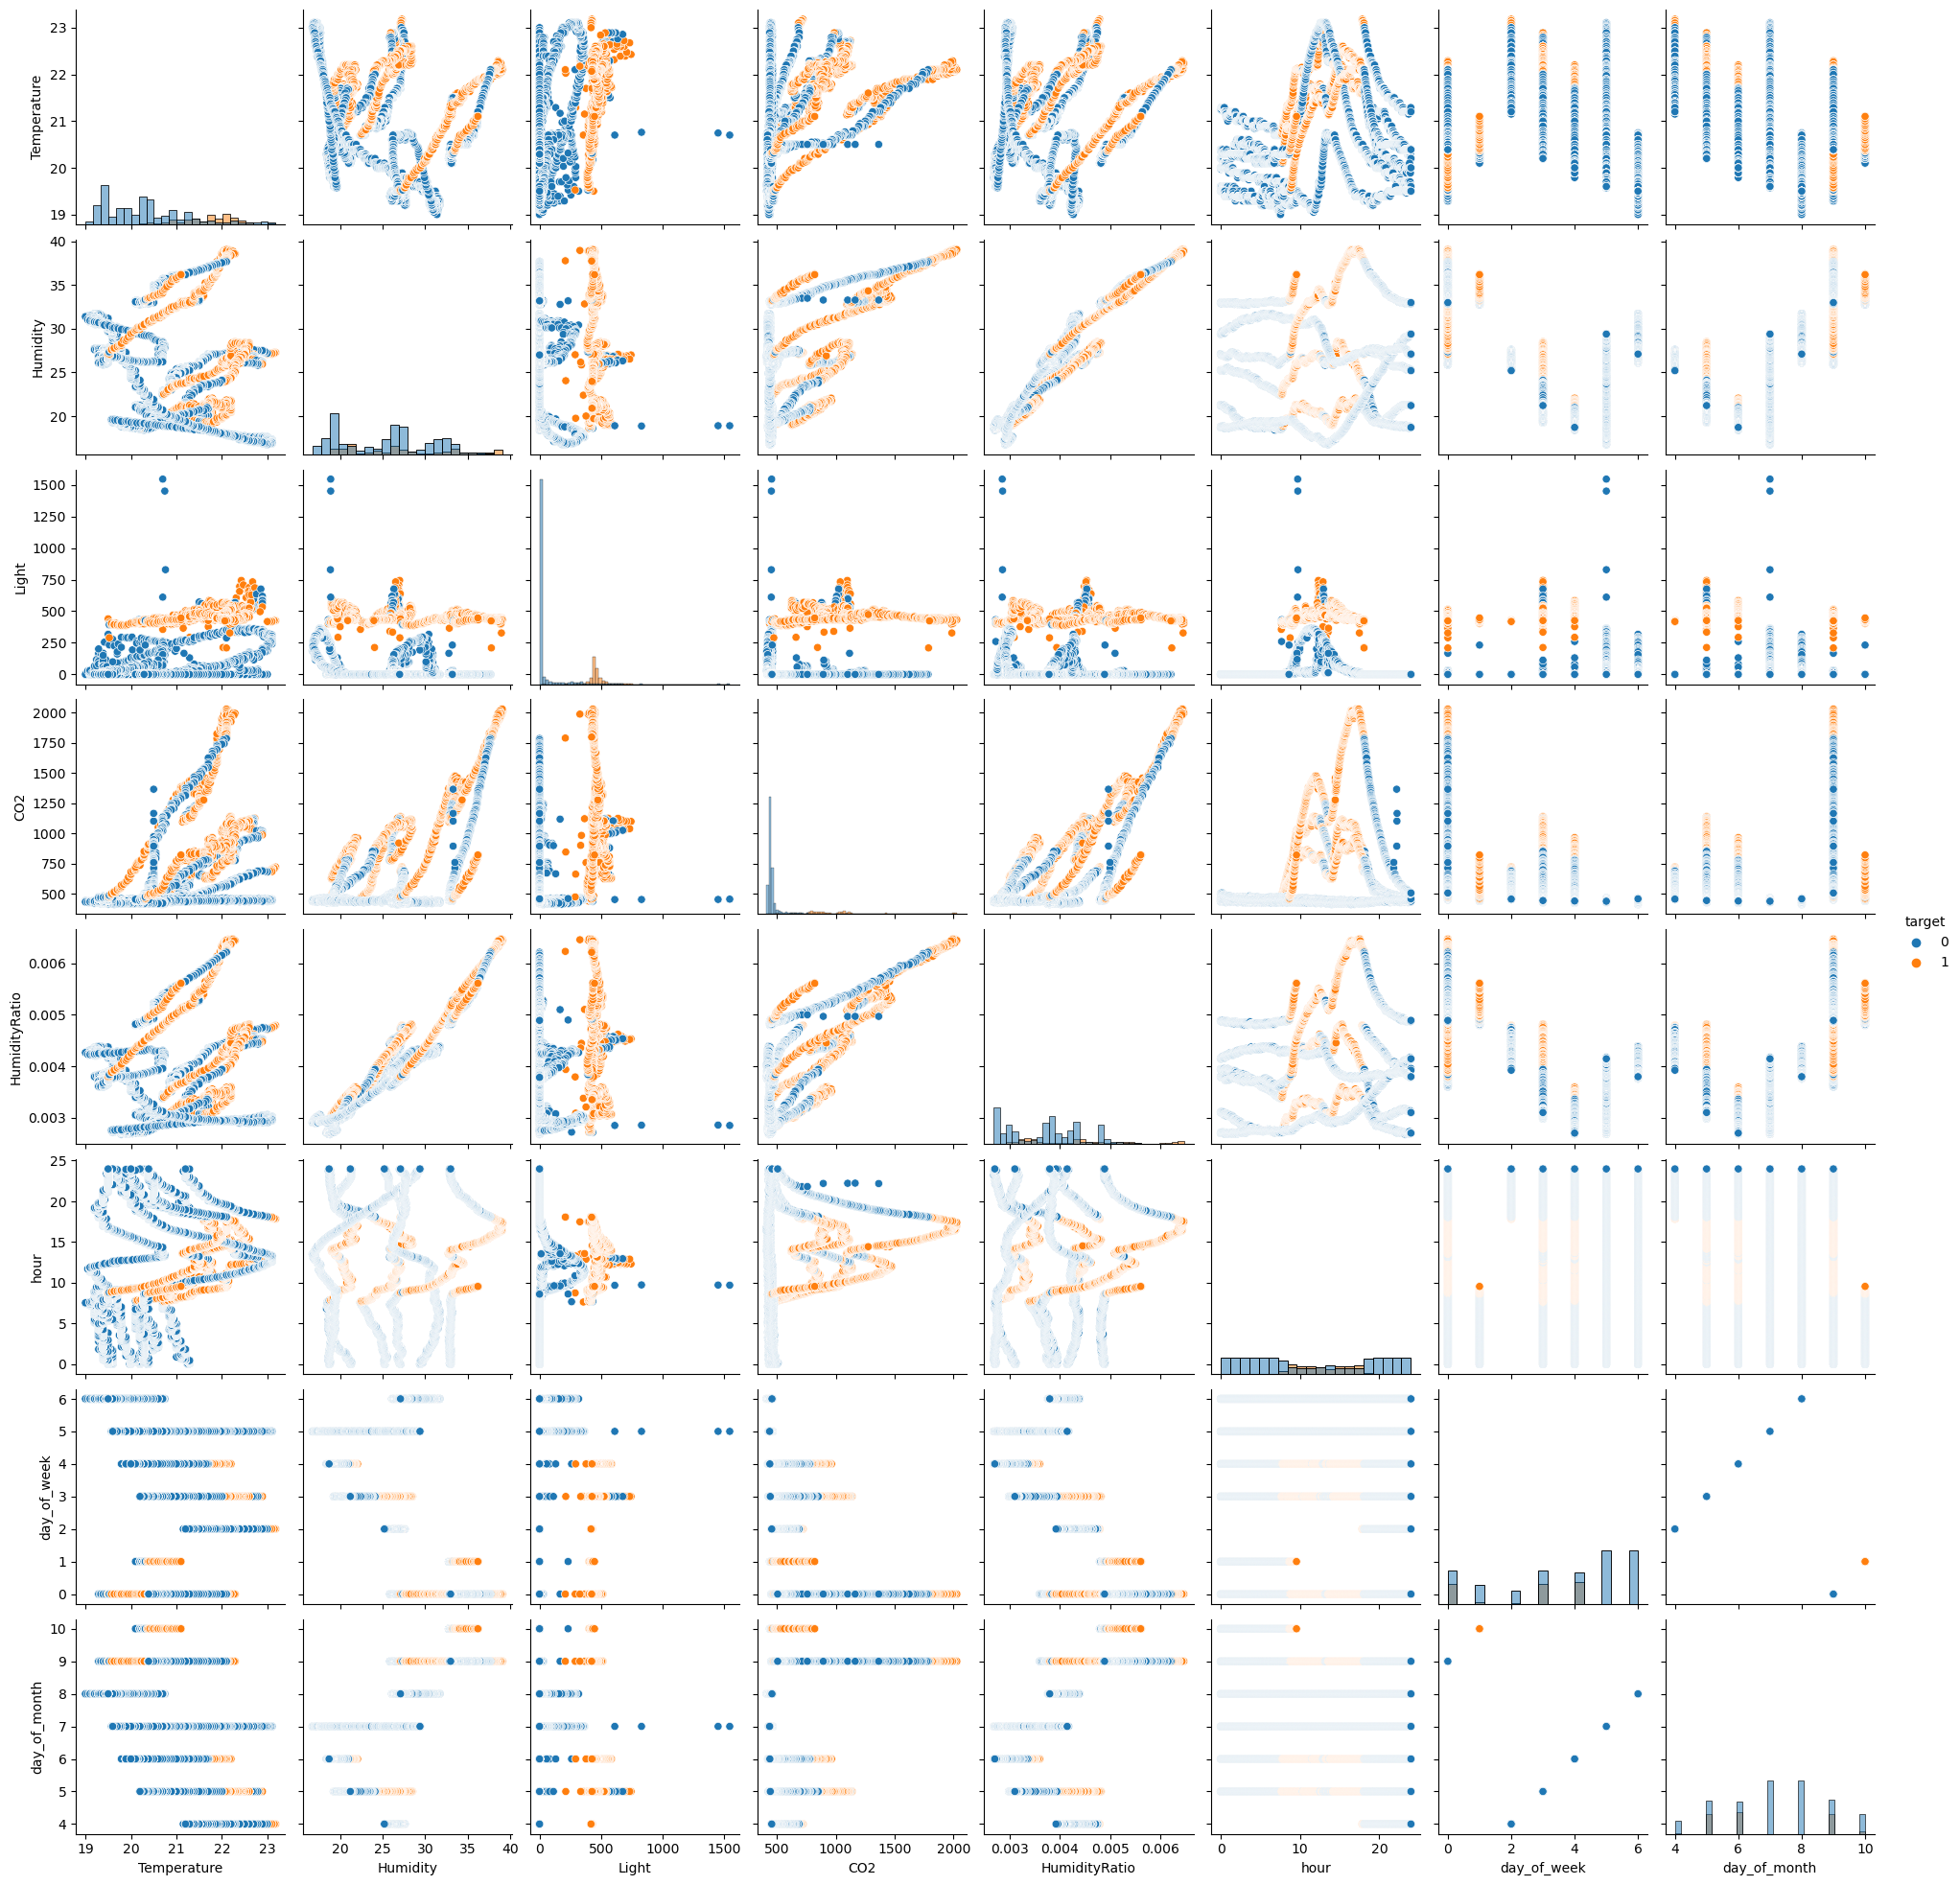

In [154]:
sns.pairplot(df, hue="target", diag_kind="hist")

Essas técnicas de visualização e a subsequente seleção de variáveis são motivadas pela necessidade de compreender as características do dataset que são mais relevantes para o problem, maximizar o desempenho do modelo e garantir que ele seja tão simples quanto possível, mas não mais simples do que isso. A simplicidade pode melhorar a interpretabilidade e a generalização do modelo para dados não vistos. 

Os gráficos gerados com `sns.pairplot` proporcionam uma visão detalhada das relações entre pares de variáveis no conjunto de dados e como essas relações diferem entre as classes da variável `target`. Algumas observações:

* Relações Lineares Claras: Alguns gráficos mostram relações lineares claras, como entre `Light` e `target`, indicando que `Light` é um bom preditor para a ocupação. O mesmo vale para `CO2` e `target`.

* Distribuições de Variáveis: Os histogramas na diagonal principal mostram a distribuição de cada variável para as diferentes classes da variável alvo. Parece haver uma diferença distinta nas distribuições de `Light` e `CO2` para as diferentes classes de `target`, reforçando a ideia de que estas são características importantes.

* Relações Não Lineares e Interativas: Alguns gráficos de dispersão não mostram uma relação linear direta entre as variáveis e a `target`, mas podem indicar a presença de relações não lineares ou interações entre variáveis. Por exemplo, a relação entre `Temperature` e `Humidity` parece diferir dependendo da ocupação.

* Variáveis Temporais: Os gráficos para `hour`, `day_of_week` e `day_of_month` não mostram uma relação clara com a target à primeira vista. No entanto, podem existir padrões mais complexos que um gráfico de dispersão simples não pode capturar.

* Separação de Classes: Em alguns gráficos, as classes de `target` estão bem separadas baseadas em certas variáveis, o que é um bom indicativo de que essas variáveis são preditores significativos.


## Parte II. Treinamento do modelo de Rede Neural - Baseline 

Total: 1,0 pts.

### 1)	Com as configurações do modelo MLP previamente definidas no script, faça o treinamento da Rede Neural sem normalizar os atributos numéricos. Comente o resultado obtido, baseado nas métricas de avaliação disponíveis (acurácia, precision, recall, F1-Score, Matriz de confusão, etc.)

In [155]:
new_df = transform_data(df, normalize=False)
#new_df.head()

In [156]:
new_df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,target,hour,day_of_week,day_of_month
0,23.18,27.2720,426.0,721.25,0.004793,1,17.850000,2,4
1,23.15,27.2675,429.5,714.00,0.004783,1,17.866389,2,4
2,23.15,27.2450,426.0,713.50,0.004779,1,17.883333,2,4
3,23.15,27.2000,426.0,708.25,0.004772,1,17.900000,2,4
4,23.10,27.2000,426.0,704.50,0.004757,1,17.916667,2,4


In [157]:
X = new_df.values[:,:-1]#.astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]

Multiclass classification


In [158]:
batch_size = 32 
epochs = 170

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [78]:

#Para o caso de múltiplas classes
# train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
# val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
# test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())



No nosso caso, estamos tentando resolver um problema de classificação binária, pois nossa variável alvo tem apenas 2 estados.

In [160]:
#Para o caso binário
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [161]:
train_dataset.X_data

tensor([[ 21.7000,  20.3900, 512.7500,  ...,   1.0000,  12.1997,   4.0000],
        [ 19.6500,  19.3400,   0.0000,  ...,   0.0000,   7.5333,   5.0000],
        [ 22.9725,  16.7900, 181.5000,  ...,   0.0000,  13.5667,   5.0000],
        ...,
        [ 22.2000,  38.4333, 429.5000,  ...,   1.0000,  17.6333,   0.0000],
        [ 21.2675,  32.9500,  13.0000,  ...,   0.0000,  13.4664,   0.0000],
        [ 22.4633,  28.3267, 527.0000,  ...,   1.0000,  14.9831,   3.0000]])

In [162]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')

In [163]:
lr = 0.01
epochs = 250

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.324 | Val Loss: 1.9614 | Train Acc: 17.8650| Val Acc: 18.0000
Epoch 002: | Train Loss: 1.937 | Val Loss: 1.9297 | Train Acc: 17.9018| Val Acc: 18.0000
Epoch 003: | Train Loss: 1.912 | Val Loss: 1.9083 | Train Acc: 17.9018| Val Acc: 18.0000
Epoch 004: | Train Loss: 1.895 | Val Loss: 1.8937 | Train Acc: 17.9018| Val Acc: 18.0000
Epoch 005: | Train Loss: 1.884 | Val Loss: 1.8836 | Train Acc: 17.9018| Val Acc: 18.0000
Epoch 006: | Train Loss: 1.876 | Val Loss: 1.8765 | Train Acc: 17.9018| Val Acc: 18.0000
Epoch 007: | Train Loss: 1.871 | Val Loss: 1.8715 | Train Acc: 17.6012| Val Acc: 18.0000
Epoch 008: | Train Loss: 1.867 | Val Loss: 1.8679 | Train Acc: 17.0245| Val Acc: 18.0000
Epoch 009: | Train Loss: 1.864 | Val Loss: 1.8652 | Train Acc: 17.5767| Val Acc: 17.0000
Epoch 010: | Train Loss: 1.862 | Val Loss: 1.8633 | Train Acc: 17.9325| Val Acc: 17.0000
Epoch 011: | Train Loss: 1.861 | Val Loss: 1.8618 | Train Acc: 17.8650| Val Acc: 17.0000
Epoch 012: | Train Lo

In [164]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.00      0.00      0.00       309
           2       0.00      0.00      0.00       274
           3       0.00      0.00      0.00       291
           4       0.00      0.00      0.00       276
           5       0.17      1.00      0.29       271
           6       0.00      0.00      0.00       130

    accuracy                           0.17      1629
   macro avg       0.02      0.14      0.04      1629
weighted avg       0.03      0.17      0.05      1629



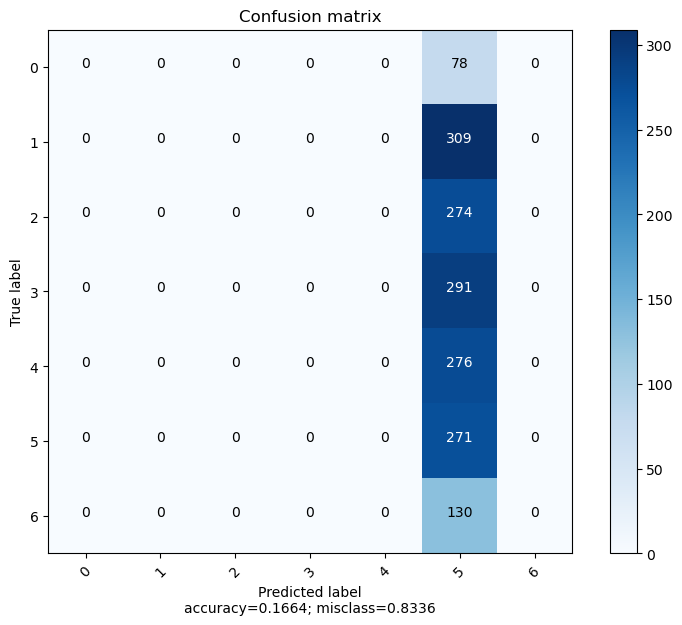

In [165]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Análise:

Com base nos resultados obtidos, podemos fazer algumas observações:

* Acurácia: A acurácia geral da rede é de aproximadamente 17%. É uma taxa de acerto bastante baixa, indicando que o modelo tem dificuldade em classificar corretamente as entradas.

* Matriz de Confusão: A matriz de confusão mostra que há uma concentração de predições em uma classe específica (label 5). Isso indica que a rede está tendenciosa para essa classe, possivelmente devido a um desequilíbrio no conjunto de dados ou a uma falha no aprendizado.

* Precision e Recall: Ambos precision e recall são 0 para quase todas as classes, exceto para a classe onde há tendência de predição, indicando que, para essa classe específica, o modelo tem alguma capacidade de detectar as entradas corretamente mas ainda assim com performance muito baixa.

* F1-Score: O F1-Score, que é uma média harmônica entre precision e recall, também é muito baixo, refletindo a baixa performance do modelo em todas as classes, exceto na classe tendenciosa.

* UndefinedMetricWarning: Os avisos indicam que os cálculos de precision e recall não podem ser realizados para algumas classes, provavelmente porque essas classes não aparecem nas predições ou não há verdadeiros positivos, levando a um denominador zero no cálculo dessas métricas.

Esses resultados sugerem que o modelo pode estar sofrendo de vários problemas, como sobreajuste a uma classe específica, desequilíbrio de classe, ou que a ausência de normalização dos atributos numéricos impactou negativamente o processo de aprendizado. A normalização costuma ser uma prática importante que ajuda a garantir que cada atributo contribua igualmente para o processo de aprendizado e melhora a convergência do treinamento. Como não normalizamos, os atributos com maior magnitude podem dominar o gradiente, levando a um treinamento ineficiente e a um modelo que não generaliza bem.

Em suma, para melhorar o modelo, poderíamos considerar a normalização dos dados e investigar o balanceamento das classes. Além disso, ajustes no modelo, como alterações na arquitetura da rede neural ou no processo de treinamento, podem ser necessários para melhorar o desempenho nas tarefas de classificação.

## Parte III - Mudança de configurações do modelo

Total: 8,0 pts.

### 1)	Agora normalize os dados de entrada e treine novamente o modelo MLP. Avalie os resultados obtidos e comente o efeito da normalização no treinamento da Rede Neural.

In [167]:
new_df = transform_data(df, normalize=True)
new_df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,target,hour,day_of_week,day_of_month
0,1.000000,0.470533,0.275490,0.190933,0.557318,1,0.744275,0.333333,0.0
1,0.992823,0.470332,0.277754,0.186446,0.554807,1,0.744959,0.333333,0.0
2,0.992823,0.469326,0.275490,0.186136,0.553761,1,0.745665,0.333333,0.0
3,0.992823,0.467315,0.275490,0.182887,0.551669,1,0.746360,0.333333,0.0
4,0.980861,0.467315,0.275490,0.180566,0.547851,1,0.747055,0.333333,0.0


In [168]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  #y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

Multiclass classification


In [169]:
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [170]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.895 | Val Loss: 1.8865 | Train Acc: 18.0798| Val Acc: 17.0000
Epoch 002: | Train Loss: 1.866 | Val Loss: 1.8611 | Train Acc: 18.0798| Val Acc: 17.0000
Epoch 003: | Train Loss: 1.845 | Val Loss: 1.8406 | Train Acc: 18.0798| Val Acc: 17.0000
Epoch 004: | Train Loss: 1.826 | Val Loss: 1.8205 | Train Acc: 21.6810| Val Acc: 25.0000
Epoch 005: | Train Loss: 1.805 | Val Loss: 1.7980 | Train Acc: 29.2209| Val Acc: 27.0000
Epoch 006: | Train Loss: 1.779 | Val Loss: 1.7705 | Train Acc: 31.1656| Val Acc: 30.0000
Epoch 007: | Train Loss: 1.747 | Val Loss: 1.7357 | Train Acc: 35.6012| Val Acc: 35.0000
Epoch 008: | Train Loss: 1.706 | Val Loss: 1.6914 | Train Acc: 38.2883| Val Acc: 37.0000
Epoch 009: | Train Loss: 1.654 | Val Loss: 1.6361 | Train Acc: 44.0859| Val Acc: 44.0000
Epoch 010: | Train Loss: 1.594 | Val Loss: 1.5763 | Train Acc: 47.3620| Val Acc: 46.0000
Epoch 011: | Train Loss: 1.532 | Val Loss: 1.5151 | Train Acc: 48.0491| Val Acc: 45.0000
Epoch 012: | Train Lo

In [171]:
y_pred = model.predict(test_dataset.X_data,binary=binary)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      1.00      1.00       309
           2       1.00      0.97      0.98       274
           3       0.97      0.96      0.96       291
           4       0.96      1.00      0.98       276
           5       1.00      1.00      1.00       271
           6       1.00      1.00      1.00       130

    accuracy                           0.99      1629
   macro avg       0.99      0.99      0.99      1629
weighted avg       0.99      0.99      0.99      1629



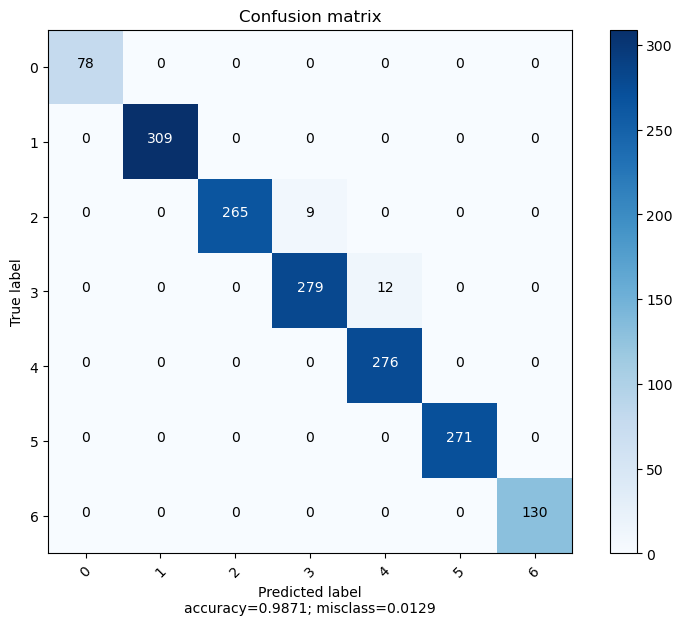

In [172]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Análise:

Com base nas métricas antes e após a normalização, podemos observar uma diferença significativa no desempenho do modelo. Antes da normalização, a acurácia estava em torno de 17%, indicando que o modelo mal estava se saindo melhor do que um chute aleatório, considerando que o dataset tem múltiplas classes. Após a normalização dos dados, a acurácia subiu para 99%.

Percebemos que a normalização dos atributos é um passo crítico no pré-processamento. Os atributos numéricos podem ter uma grande variação nas suas escalas e, consequentemente, nos seus intervalos de valores. Isso pode levar a problemas no treinamento, já que modelos baseados em gradiente (como redes neurais) serão mais sensíveis às variáveis com escalas maiores. Normalizar os dados garante que cada atributo contribua igualmente para o cálculo da função de custo e ajuda o algoritmo de aprendizado a convergir mais rapidamente.

Além disso, a matriz de confusão após a normalização mostra uma distribuição muito melhor nas previsões corretas, com a maioria das previsões concentrando-se na diagonal, que representa as classificações corretas. A métrica F1-Score, que é a média harmônica entre precisão e recall, também melhorou significativamente após a normalização, refletindo uma alta precisão e uma alta taxa de recuperação de informações relevantes.

Em suma, a normalização dos dados teve um efeito muito positivo no treinamento da Rede Neural, levando a uma melhoria significativa nas métricas de avaliação. Isso ressalta a importância do pré-processamento de dados e da normalização como uma etapa crítica para melhorar o desempenho do modelo em tarefas de classificação.

### 2)	Modifique o tempo de treinamento (épocas) da Rede Neural. Escolha valores distintos (e.g. 1 e 1000 épocas) e avalie os resultados.

#### Treinando com 05 épocas

In [174]:
lr = 0.01
epochs = 5
activation_function = 'sigmoid'

model = NeuralNetwork(n_input=n_input, n_output=n_output,
                    output_activation=activation_function)

history, y_hat = train(model, train_loader, val_dataset,
                    epochs=epochs, lr=lr, device=device, binary=binary)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.874 | Val Loss: 1.8595 | Train Acc: 19.8405| Val Acc: 22.0000
Epoch 002: | Train Loss: 1.842 | Val Loss: 1.8291 | Train Acc: 23.2761| Val Acc: 23.0000
Epoch 003: | Train Loss: 1.811 | Val Loss: 1.7979 | Train Acc: 24.0123| Val Acc: 24.0000
Epoch 004: | Train Loss: 1.777 | Val Loss: 1.7628 | Train Acc: 24.9571| Val Acc: 25.0000
Epoch 005: | Train Loss: 1.738 | Val Loss: 1.7211 | Train Acc: 28.5153| Val Acc: 31.0000


c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.00      0.00      0.00       309
           2       0.21      0.66      0.32       274
           3       0.00      0.00      0.00       291
           4       0.13      0.08      0.10       276
           5       0.45      1.00      0.62       271
           6       0.00      0.00      0.00       130

    accuracy                           0.29      1629
   macro avg       0.11      0.25      0.15      1629
weighted avg       0.13      0.29      0.17      1629



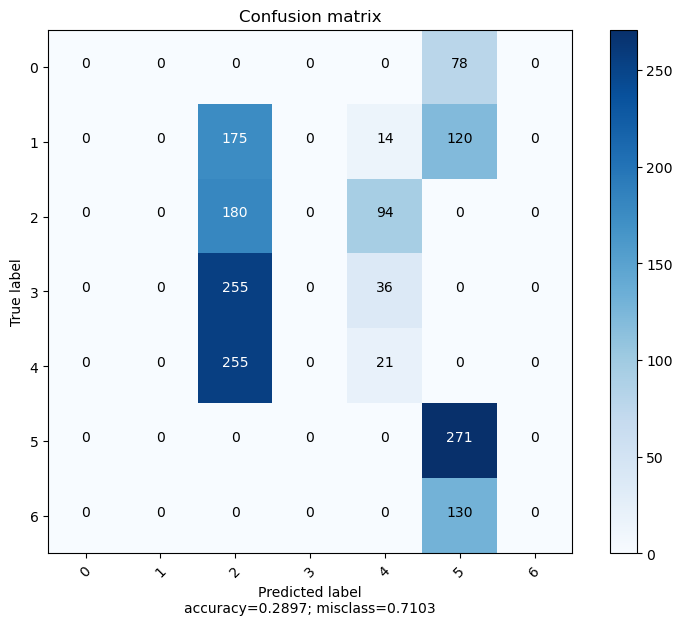

In [175]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Treinando com 01 época

In [176]:
lr = 0.01
epochs = 1
activation_function = 'sigmoid'

model = NeuralNetwork(n_input=n_input, n_output=n_output,
                    output_activation=activation_function)

history, y_hat = train(model, train_loader, val_dataset,
                    epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.964 | Val Loss: 1.9233 | Train Acc: 10.1902| Val Acc: 19.0000


c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.19      1.00      0.32       309
           2       0.00      0.00      0.00       274
           3       0.00      0.00      0.00       291
           4       0.00      0.00      0.00       276
           5       0.00      0.00      0.00       271
           6       0.00      0.00      0.00       130

    accuracy                           0.19      1629
   macro avg       0.03      0.14      0.05      1629
weighted avg       0.04      0.19      0.06      1629



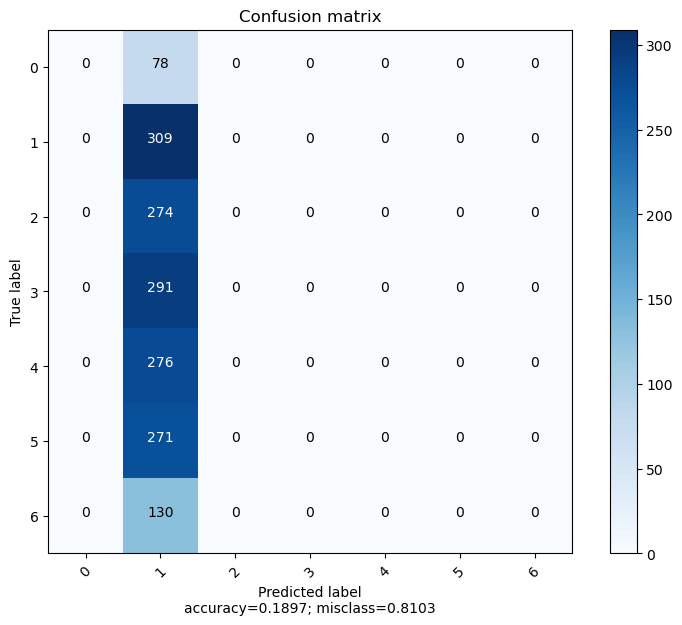

In [177]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Treinando com 1000 épocas

In [178]:
lr = 0.01
epochs = 1000
activation_function = 'sigmoid'

model = NeuralNetwork(n_input=n_input, n_output=n_output,
                    output_activation=activation_function)

history, y_hat = train(model, train_loader, val_dataset,
                    epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.942 | Val Loss: 1.9000 | Train Acc: 19.0368| Val Acc: 22.0000
Epoch 002: | Train Loss: 1.877 | Val Loss: 1.8551 | Train Acc: 24.5399| Val Acc: 22.0000
Epoch 003: | Train Loss: 1.838 | Val Loss: 1.8224 | Train Acc: 26.0736| Val Acc: 28.0000
Epoch 004: | Train Loss: 1.805 | Val Loss: 1.7901 | Train Acc: 28.7791| Val Acc: 33.0000
Epoch 005: | Train Loss: 1.770 | Val Loss: 1.7560 | Train Acc: 35.6196| Val Acc: 38.0000
Epoch 006: | Train Loss: 1.734 | Val Loss: 1.7189 | Train Acc: 45.6442| Val Acc: 50.0000
Epoch 007: | Train Loss: 1.694 | Val Loss: 1.6789 | Train Acc: 49.4356| Val Acc: 48.0000
Epoch 008: | Train Loss: 1.652 | Val Loss: 1.6362 | Train Acc: 48.8712| Val Acc: 48.0000
Epoch 009: | Train Loss: 1.607 | Val Loss: 1.5916 | Train Acc: 48.7730| Val Acc: 48.0000
Epoch 010: | Train Loss: 1.561 | Val Loss: 1.5456 | Train Acc: 48.6994| Val Acc: 48.0000
Epoch 011: | Train Loss: 1.514 | Val Loss: 1.4993 | Train Acc: 48.8221| Val Acc: 49.0000
Epoch 012: | Train Lo

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      1.00      1.00       309
           2       1.00      1.00      1.00       274
           3       1.00      1.00      1.00       291
           4       1.00      1.00      1.00       276
           5       1.00      1.00      1.00       271
           6       1.00      1.00      1.00       130

    accuracy                           1.00      1629
   macro avg       1.00      1.00      1.00      1629
weighted avg       1.00      1.00      1.00      1629



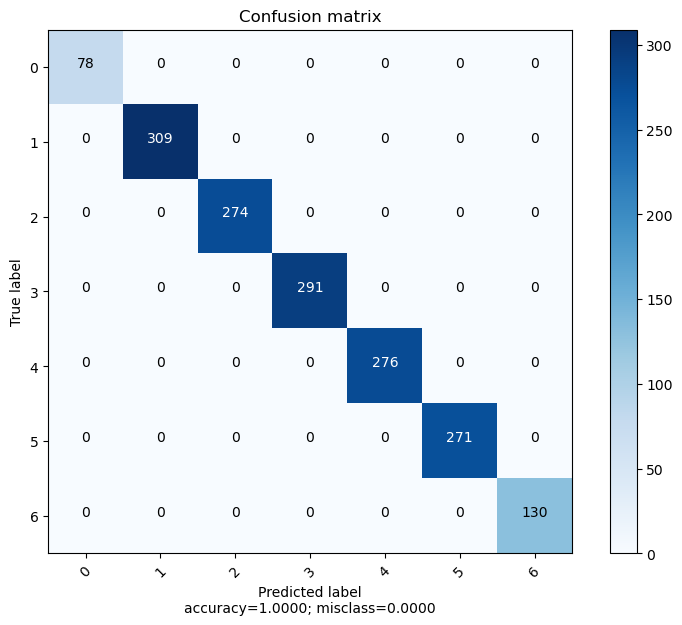

In [179]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

#### Análise

Os resultados mostram uma melhoria significativa no desempenho da rede neural à medida que o número de épocas de treinamento aumenta. Primeiramente, treinamos com 5 épocas, depois com 1 época e ao final treinamos com 1000 épocas.

* Com 5 Épocas: A acurácia é relativamente baixa e a matriz de confusão mostra muitas classificações incorretas. Este é um indicativo claro de underfitting, onde a rede não teve épocas suficientes para aprender adequadamente os padrões nos dados.

* Com 1 Época: A acurácia é ainda mais baixa e a matriz de confusão sugere que o modelo está essencialmente chutando aleatoriamente, resultando em um número muito alto de classificações incorretas.

* Com 1000 Épocas: A acurácia atinge o valor perfeito de 100%, e a matriz de confusão mostra que todas as previsões estão corretas, o que é uma indicação de overfitting. Embora o modelo tenha se saído perfeitamente nos dados de teste, isso pode não se traduzir em um bom desempenho em novos dados não vistos devido ao overfitting.

A diferença drástica entre os resultados com 1, 5 e 1000 épocas ilustra a importância de escolher um número adequado de épocas para treinamento. Poucas épocas não são suficientes para que o modelo aprenda, enquanto muitas épocas podem levar a um modelo que se ajusta demais aos dados de treinamento e pode não generalizar bem para dados novos. Para contextualizar, uma boa estratégia para escolher o número de épocas ideal envolve o uso de uma técnica chamada early stopping, que consiste em interromper o treinamento quando o desempenho em um conjunto de validação começa a piorar, indicando que o modelo pode estar começando a sofrer de overfitting.

### 3)	 Modifique a taxa de aprendizado da Rede Neural. Escolha valores distintos (e.g. 0,001 e 0,1) e avalie os resultados.

#### Treinando com uma taxa de 0.001 e 250 épocas

In [180]:
lr = 0.001
epochs = 250
activation_function = 'sigmoid'

model = NeuralNetwork(n_input=n_input, n_output=n_output,
                    output_activation=activation_function)

history, y_hat = train(model, train_loader, val_dataset,
                    epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.053 | Val Loss: 2.0393 | Train Acc: 6.6135| Val Acc: 7.0000
Epoch 002: | Train Loss: 2.035 | Val Loss: 2.0234 | Train Acc: 7.8282| Val Acc: 10.0000
Epoch 003: | Train Loss: 2.019 | Val Loss: 2.0091 | Train Acc: 11.5828| Val Acc: 15.0000
Epoch 004: | Train Loss: 2.006 | Val Loss: 1.9960 | Train Acc: 13.4356| Val Acc: 15.0000
Epoch 005: | Train Loss: 1.993 | Val Loss: 1.9840 | Train Acc: 14.4663| Val Acc: 18.0000
Epoch 006: | Train Loss: 1.981 | Val Loss: 1.9728 | Train Acc: 19.6442| Val Acc: 21.0000
Epoch 007: | Train Loss: 1.970 | Val Loss: 1.9623 | Train Acc: 22.3190| Val Acc: 23.0000
Epoch 008: | Train Loss: 1.959 | Val Loss: 1.9525 | Train Acc: 22.5890| Val Acc: 22.0000
Epoch 009: | Train Loss: 1.950 | Val Loss: 1.9431 | Train Acc: 19.9693| Val Acc: 18.0000
Epoch 010: | Train Loss: 1.940 | Val Loss: 1.9343 | Train Acc: 18.3804| Val Acc: 18.0000
Epoch 011: | Train Loss: 1.931 | Val Loss: 1.9258 | Train Acc: 18.2515| Val Acc: 18.0000
Epoch 012: | Train Loss:

c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.76      0.78      0.77       309
           2       0.55      0.49      0.52       274
           3       0.59      0.69      0.64       291
           4       0.85      1.00      0.92       276
           5       0.68      1.00      0.81       271
           6       0.00      0.00      0.00       130

    accuracy                           0.69      1629
   macro avg       0.49      0.57      0.52      1629
weighted avg       0.60      0.69      0.64      1629



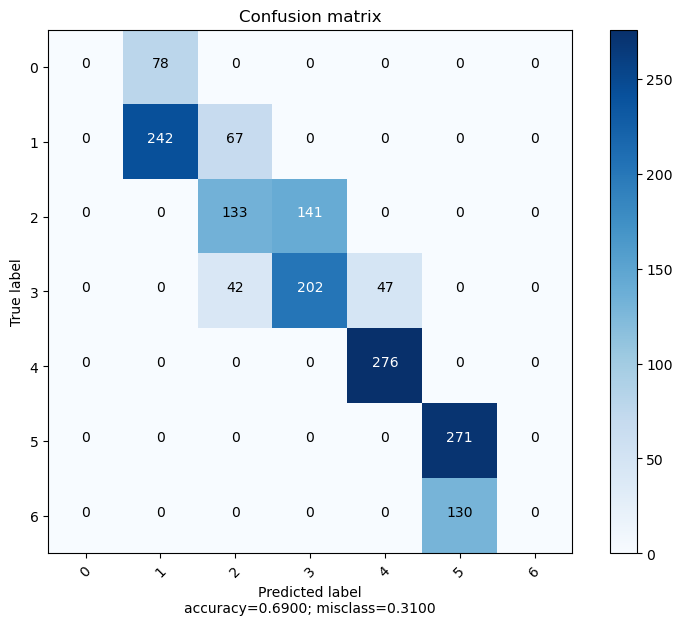

In [181]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Treinando com uma taxa de 0.05 e 250 épocas

In [183]:
lr = 0.05
epochs = 250
activation_function = 'sigmoid'

model = NeuralNetwork(n_input=n_input, n_output=n_output,
                    output_activation=activation_function)

history, y_hat = train(model, train_loader, val_dataset,
                    epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.911 | Val Loss: 1.8408 | Train Acc: 18.4049| Val Acc: 22.0000
Epoch 002: | Train Loss: 1.778 | Val Loss: 1.6912 | Train Acc: 33.0552| Val Acc: 48.0000
Epoch 003: | Train Loss: 1.540 | Val Loss: 1.4038 | Train Acc: 56.3252| Val Acc: 59.0000
Epoch 004: | Train Loss: 1.263 | Val Loss: 1.1608 | Train Acc: 63.5031| Val Acc: 71.0000
Epoch 005: | Train Loss: 1.065 | Val Loss: 1.0015 | Train Acc: 72.0429| Val Acc: 74.0000
Epoch 006: | Train Loss: 0.935 | Val Loss: 0.8913 | Train Acc: 74.8282| Val Acc: 76.0000
Epoch 007: | Train Loss: 0.841 | Val Loss: 0.8084 | Train Acc: 76.6012| Val Acc: 79.0000
Epoch 008: | Train Loss: 0.769 | Val Loss: 0.7422 | Train Acc: 78.7730| Val Acc: 80.0000
Epoch 009: | Train Loss: 0.710 | Val Loss: 0.6860 | Train Acc: 81.3681| Val Acc: 85.0000
Epoch 010: | Train Loss: 0.658 | Val Loss: 0.6365 | Train Acc: 83.8834| Val Acc: 86.0000
Epoch 011: | Train Loss: 0.613 | Val Loss: 0.5936 | Train Acc: 85.2393| Val Acc: 87.0000
Epoch 012: | Train Lo

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      1.00      1.00       309
           2       1.00      1.00      1.00       274
           3       1.00      1.00      1.00       291
           4       1.00      1.00      1.00       276
           5       1.00      1.00      1.00       271
           6       1.00      1.00      1.00       130

    accuracy                           1.00      1629
   macro avg       1.00      1.00      1.00      1629
weighted avg       1.00      1.00      1.00      1629



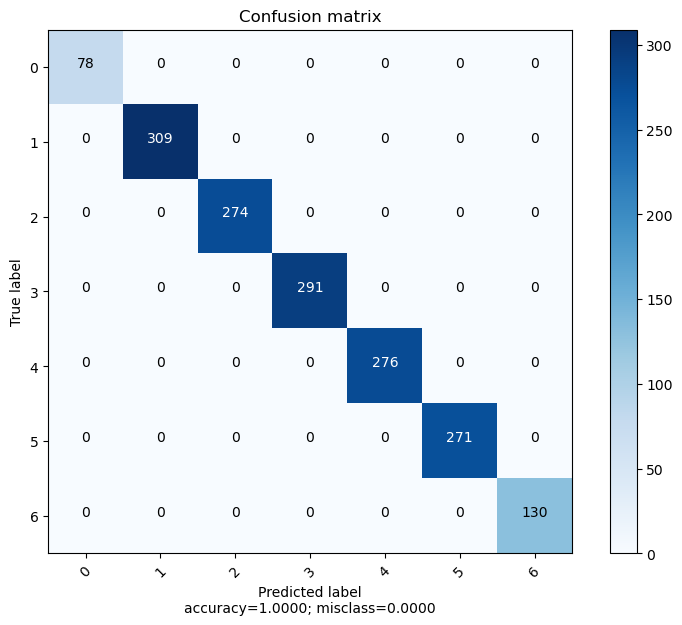

In [184]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Treinando com uma taxa de 0.1 e 150 épocas

In [185]:
lr = 0.1
epochs = 150
activation_function = 'sigmoid'

model = NeuralNetwork(n_input=n_input, n_output=n_output,
                    output_activation=activation_function)

history, y_hat = train(model, train_loader, val_dataset,
                    epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.728 | Val Loss: 1.4240 | Train Acc: 32.2883| Val Acc: 50.0000
Epoch 002: | Train Loss: 1.158 | Val Loss: 0.9770 | Train Acc: 63.9632| Val Acc: 69.0000
Epoch 003: | Train Loss: 0.860 | Val Loss: 0.7740 | Train Acc: 74.1227| Val Acc: 75.0000
Epoch 004: | Train Loss: 0.704 | Val Loss: 0.6434 | Train Acc: 76.4724| Val Acc: 76.0000
Epoch 005: | Train Loss: 0.591 | Val Loss: 0.5412 | Train Acc: 81.1840| Val Acc: 89.0000
Epoch 006: | Train Loss: 0.500 | Val Loss: 0.4608 | Train Acc: 88.0982| Val Acc: 89.0000
Epoch 007: | Train Loss: 0.429 | Val Loss: 0.3986 | Train Acc: 90.1595| Val Acc: 90.0000
Epoch 008: | Train Loss: 0.373 | Val Loss: 0.3490 | Train Acc: 92.1043| Val Acc: 93.0000
Epoch 009: | Train Loss: 0.328 | Val Loss: 0.3083 | Train Acc: 94.6012| Val Acc: 95.0000
Epoch 010: | Train Loss: 0.290 | Val Loss: 0.2745 | Train Acc: 95.6012| Val Acc: 96.0000
Epoch 011: | Train Loss: 0.259 | Val Loss: 0.2468 | Train Acc: 96.0552| Val Acc: 96.0000
Epoch 012: | Train Lo

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      1.00      1.00       309
           2       1.00      1.00      1.00       274
           3       1.00      1.00      1.00       291
           4       1.00      1.00      1.00       276
           5       1.00      1.00      1.00       271
           6       1.00      1.00      1.00       130

    accuracy                           1.00      1629
   macro avg       1.00      1.00      1.00      1629
weighted avg       1.00      1.00      1.00      1629



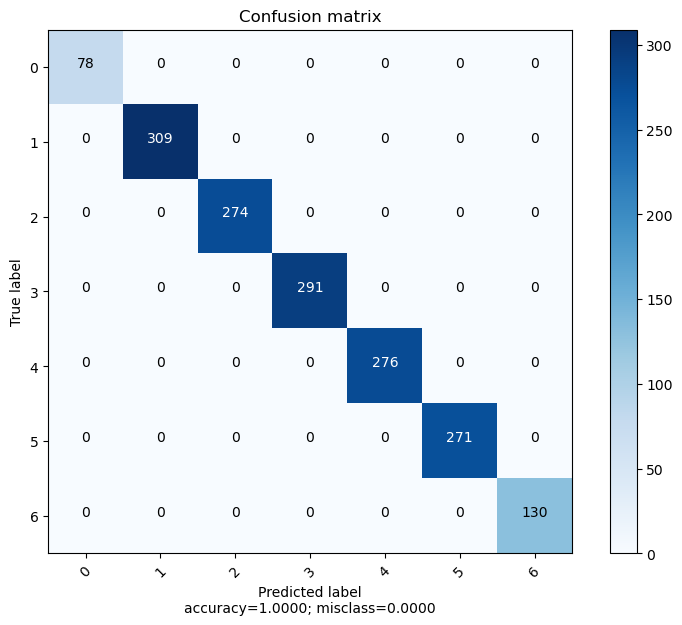

In [186]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Análise

Com base nos resultados, pudemos perceber que a rede aprendeu muito mais lentamente com uma taxa de 0.001, o que significa que não houve melhoria nas métricas de avaliação e 250 épocas não foram o suficiente para que a acurácia atingisse 100.

Já com uma taxa de 0.05 e 250 épocas, percebemos uma melhora na velocidade de aprendizado, pois a acurácia de treino já atingiu 100 na 61ª época. 

Com uma taxa de 0.1 e 150 épocas, o a rede apresentou um aprendizado melhor ainda, pois já na 36ª época atingimos uma acurácia de 100. No entanto, é interessante ressaltarmos que, ainda que uma taxa de aprendizado alta possa levar a aprendizado rápido, também pode causar instabilidade no treinamento, resultando em uma função de custo que oscila ou até aumenta ao invés de diminuir.




### 4)	Modifique a quantidade de neurônios na camada escondida da Rede Neural. Escolha valores distintos (e.g. 2 e 70 neurônios) e avalie os resultados.

#### Treinando a rede com 2 neurônios

In [187]:
lr = 0.1
epochs = 250
activation_function = 'sigmoid'
hidden_neurons = 2

model = NeuralNetwork(n_input=n_input, 
                    hidden_neurons=hidden_neurons,
                    n_output=n_output,
                    output_activation=activation_function)

history, y_hat = train(model, train_loader, val_dataset,
                    epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.861 | Val Loss: 1.8567 | Train Acc: 17.0859| Val Acc: 18.0000
Epoch 002: | Train Loss: 1.857 | Val Loss: 1.8565 | Train Acc: 16.9509| Val Acc: 18.0000
Epoch 003: | Train Loss: 1.857 | Val Loss: 1.8565 | Train Acc: 16.6810| Val Acc: 18.0000
Epoch 004: | Train Loss: 1.857 | Val Loss: 1.8565 | Train Acc: 16.8650| Val Acc: 18.0000
Epoch 005: | Train Loss: 1.857 | Val Loss: 1.8565 | Train Acc: 16.8650| Val Acc: 18.0000
Epoch 006: | Train Loss: 1.857 | Val Loss: 1.8565 | Train Acc: 16.8650| Val Acc: 18.0000
Epoch 007: | Train Loss: 1.857 | Val Loss: 1.8565 | Train Acc: 16.8650| Val Acc: 18.0000
Epoch 008: | Train Loss: 1.857 | Val Loss: 1.8565 | Train Acc: 16.8650| Val Acc: 18.0000
Epoch 009: | Train Loss: 1.857 | Val Loss: 1.8565 | Train Acc: 16.8650| Val Acc: 18.0000
Epoch 010: | Train Loss: 1.857 | Val Loss: 1.8565 | Train Acc: 16.8650| Val Acc: 18.0000
Epoch 011: | Train Loss: 1.857 | Val Loss: 1.8565 | Train Acc: 16.8650| Val Acc: 18.0000
Epoch 012: | Train Lo

c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\miniconda3\envs\nnpuc2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.00      0.00      0.00       309
           2       0.00      0.00      0.00       274
           3       0.00      0.00      0.00       291
           4       0.17      1.00      0.29       276
           5       0.00      0.00      0.00       271
           6       0.00      0.00      0.00       130

    accuracy                           0.17      1629
   macro avg       0.02      0.14      0.04      1629
weighted avg       0.03      0.17      0.05      1629



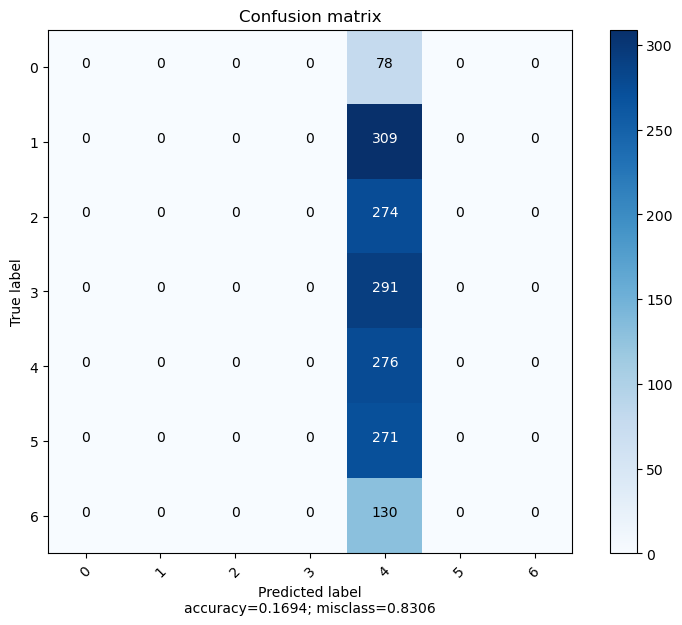

In [188]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

#### Treinando a rede com 10 neurônios

In [191]:
lr = 0.1
epochs = 250
activation_function = 'sigmoid'
hidden_neurons = 10

model = NeuralNetwork(n_input=n_input,
                    hidden_neurons=hidden_neurons,
                    n_output=n_output,
                    output_activation=activation_function)

history, y_hat = train(model, train_loader, val_dataset,
                    epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.652 | Val Loss: 1.3527 | Train Acc: 36.1902| Val Acc: 47.0000
Epoch 002: | Train Loss: 1.086 | Val Loss: 0.8690 | Train Acc: 67.1043| Val Acc: 72.0000
Epoch 003: | Train Loss: 0.720 | Val Loss: 0.6150 | Train Acc: 76.4601| Val Acc: 84.0000
Epoch 004: | Train Loss: 0.540 | Val Loss: 0.4809 | Train Acc: 83.7546| Val Acc: 84.0000
Epoch 005: | Train Loss: 0.430 | Val Loss: 0.3907 | Train Acc: 87.0184| Val Acc: 88.0000
Epoch 006: | Train Loss: 0.352 | Val Loss: 0.3248 | Train Acc: 91.3436| Val Acc: 94.0000
Epoch 007: | Train Loss: 0.294 | Val Loss: 0.2754 | Train Acc: 95.0798| Val Acc: 96.0000
Epoch 008: | Train Loss: 0.250 | Val Loss: 0.2376 | Train Acc: 96.2699| Val Acc: 97.0000
Epoch 009: | Train Loss: 0.216 | Val Loss: 0.2082 | Train Acc: 97.1227| Val Acc: 98.0000
Epoch 010: | Train Loss: 0.190 | Val Loss: 0.1846 | Train Acc: 97.6810| Val Acc: 98.0000
Epoch 011: | Train Loss: 0.168 | Val Loss: 0.1651 | Train Acc: 97.9939| Val Acc: 98.0000
Epoch 012: | Train Lo

#### Treinando a rede com 70 neurônios e taxa de 0.01

In [192]:
lr = 0.01
epochs = 250
activation_function = 'sigmoid'
hidden_neurons = 70

model = NeuralNetwork(n_input=n_input,
                    hidden_neurons=hidden_neurons,
                    n_output=n_output,
                    output_activation=activation_function)

history, y_hat = train(model, train_loader, val_dataset,
                    epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.830 | Val Loss: 1.7464 | Train Acc: 32.0920| Val Acc: 41.0000
Epoch 002: | Train Loss: 1.678 | Val Loss: 1.6221 | Train Acc: 51.6810| Val Acc: 55.0000
Epoch 003: | Train Loss: 1.554 | Val Loss: 1.5052 | Train Acc: 61.3129| Val Acc: 65.0000
Epoch 004: | Train Loss: 1.436 | Val Loss: 1.3938 | Train Acc: 66.8589| Val Acc: 67.0000
Epoch 005: | Train Loss: 1.327 | Val Loss: 1.2913 | Train Acc: 67.8221| Val Acc: 67.0000
Epoch 006: | Train Loss: 1.227 | Val Loss: 1.1990 | Train Acc: 68.4233| Val Acc: 68.0000
Epoch 007: | Train Loss: 1.139 | Val Loss: 1.1171 | Train Acc: 69.1963| Val Acc: 69.0000
Epoch 008: | Train Loss: 1.062 | Val Loss: 1.0450 | Train Acc: 69.7914| Val Acc: 69.0000
Epoch 009: | Train Loss: 0.994 | Val Loss: 0.9813 | Train Acc: 70.0675| Val Acc: 69.0000
Epoch 010: | Train Loss: 0.935 | Val Loss: 0.9253 | Train Acc: 70.7055| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.882 | Val Loss: 0.8760 | Train Acc: 71.1166| Val Acc: 70.0000
Epoch 012: | Train Lo

#### Treinando a rede com 70 neurônios e taxa de 0.1

In [193]:
lr = 0.1
epochs = 250
activation_function = 'sigmoid'
hidden_neurons = 70

model = NeuralNetwork(n_input=n_input,
                    hidden_neurons=hidden_neurons,
                    n_output=n_output,
                    output_activation=activation_function)

history, y_hat = train(model, train_loader, val_dataset,
                    epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.391 | Val Loss: 0.9700 | Train Acc: 59.3313| Val Acc: 69.0000
Epoch 002: | Train Loss: 0.758 | Val Loss: 0.6234 | Train Acc: 72.6687| Val Acc: 74.0000
Epoch 003: | Train Loss: 0.530 | Val Loss: 0.4641 | Train Acc: 83.2331| Val Acc: 87.0000
Epoch 004: | Train Loss: 0.406 | Val Loss: 0.3669 | Train Acc: 90.7730| Val Acc: 93.0000
Epoch 005: | Train Loss: 0.326 | Val Loss: 0.3018 | Train Acc: 93.8589| Val Acc: 95.0000
Epoch 006: | Train Loss: 0.271 | Val Loss: 0.2549 | Train Acc: 95.7117| Val Acc: 96.0000
Epoch 007: | Train Loss: 0.230 | Val Loss: 0.2191 | Train Acc: 96.6748| Val Acc: 97.0000
Epoch 008: | Train Loss: 0.198 | Val Loss: 0.1907 | Train Acc: 97.2147| Val Acc: 97.0000
Epoch 009: | Train Loss: 0.172 | Val Loss: 0.1674 | Train Acc: 97.6810| Val Acc: 98.0000
Epoch 010: | Train Loss: 0.151 | Val Loss: 0.1479 | Train Acc: 98.1411| Val Acc: 98.0000
Epoch 011: | Train Loss: 0.134 | Val Loss: 0.1314 | Train Acc: 98.4908| Val Acc: 98.0000
Epoch 012: | Train Lo

#### Análise

Analisando os registros de treino, podemos ver o impacto de diferentes hiperparâmetros no desempenho do modelo. Podemos fazer um resumo comparativo:

* No treino com 2 neurônios e uma taxa de aprendizado de 0.1, o modelo tem dificuldades para aprender, com a acurácia de validação final parada em 18%.

* Quando utilizando 10 neurônios e uma taxa de aprendizado de 0.1, o modelo alcança acurácia perfeita de treino e validação relativamente rápido, chegando a 100% já na época 181 e mantendo consistentemente até a época 250.

* Para o treino com 70 neurônios e uma taxa de aprendizado de 0.01, o desempenho do modelo melhora de forma estável, alcançando uma acurácia de treino de cerca de 100% na época 100 e mantendo uma acurácia de validação de 98% por volta da época 80.

* Finalmente, com 70 neurônios e uma taxa de aprendizado maior de 0.1, o modelo rapidamente alcança acurácia perfeita de treino e validação, fazendo isso por volta da época 20.

Estes registros indicam que aumentar o número de neurônios pode melhorar significativamente a velocidade de aprendizado e o desempenho final do modelo, até certo ponto em que pode atingir um ajuste perfeito aos dados de treino. O aumento na taxa de aprendizado para o teste com 70 neurônios foi feito apenas para fins de comparação e contextualização.